# bRocket Logger Decoder
This script takes a binary file from the bRocket logger and decodes the values according to datatype, saves them in a .CSV and plots them

## I. Decode Data

In [1]:
# NECESSARY INPUTS
fn = 'bR_0101000001_032.dat' # 1st rocket flight
# Select Time-Window
start_time = 220;
end_time = 250;

In [2]:
import numpy as np
import pandas as pd

dtype = np.dtype([
   ('time [s]', '<u4'),   # little-endian unsigned 32-bit integer
   ('dt [s]', '<u2'),   # little-endian unsigned 16-bit integer
   ('aX [m/s^2]', '<i2'),   # little-endian signed 16-bit integer
   ('aY [m/s^2]', '<i2'),   # little-endian signed 16-bit integer
   ('aZ [m/s^2]', '<i2'),   # little-endian signed 16-bit integer
   ('gX [°/s]', '<i2'),   # little-endian signed 16-bit integer
   ('gY [°/s]', '<i2'),   # little-endian signed 16-bit integer
   ('gZ [°/s]', '<i2'),   # little-endian signed 16-bit integer
   ('alt [m]', '<i2'),   # little-endian signed 16-bit integer
   ('temp [C]', '<i2'),    # little-endian signed 16-bit integer
   ('placeholder', '<i2')    # little-endian signed 16-bit integer
])

scaling_factors = {
 'time [s]': 1e-3,
 'dt [s]': 1e-6,
 'aX [m/s^2]': 1e-2,
 'aY [m/s^2]': 1e-2,
 'aZ [m/s^2]': 1e-2,
 'gX [°/s]': 1e-1,
 'gY [°/s]': 1e-1,
 'gZ [°/s]': 1e-1,
 'alt [m]': 1e-1,
 'temp [C]': 1e-1,
 'placeholder': 0
}

## READ IN DATA
with open(fn, 'rb') as f:  
    log = np.fromfile(f, dtype=dtype)

# CONVERT TO FLOATS
fields = log.dtype.names
new_dtype = np.dtype([(field, 'float64') for field in fields])
log_floats = np.empty_like(log, dtype=new_dtype)
for field in fields:
    log_floats[field] = log[field].astype('float64')
    
## MULTIPLY by factors
for field, scaling_factors in scaling_factors.items():
    log_floats[field] = log_floats[field] * scaling_factors

## CONVERT TO Pandas DATAFRAME
df_all = pd.DataFrame(log_floats)

# SELECT DATA Window
mask = (df_all['time [s]'] > start_time) & (df_all['time [s]'] < end_time)
df = df_all.loc[mask] # Cut Data Frame with mask

df.set_index('time [s]', inplace=True) # Set time as the index

In [3]:
## SAVE Dataframe to CSV file with precision 5
df.to_csv('log.csv', float_format='%.5f', index=True)

## II. Visualization

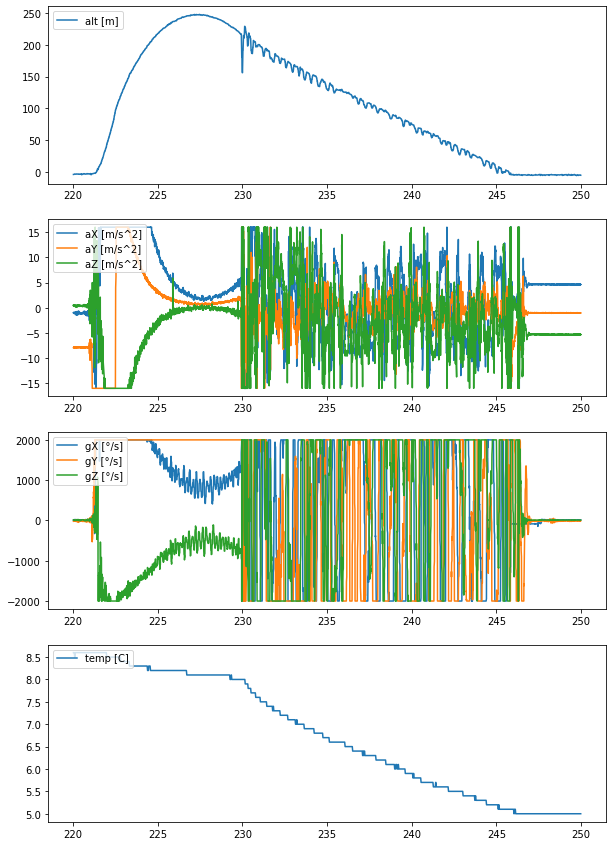

In [4]:
# Plot & Save figure
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, figsize=(10, 15)) # Adjust the size as needed

axs[0].plot(df['alt [m]'], label='alt [m]')
axs[1].plot(df['aX [m/s^2]'], label='aX [m/s^2]')
axs[1].plot(df['aY [m/s^2]'], label='aY [m/s^2]')
axs[1].plot(df['aZ [m/s^2]'], label='aZ [m/s^2]')
axs[2].plot(df['gX [°/s]'], label='gX [°/s]')
axs[2].plot(df['gY [°/s]'], label='gY [°/s]')
axs[2].plot(df['gZ [°/s]'], label='gZ [°/s]')
axs[3].plot(df['temp [C]'], label='temp [C]')

# Add legends
axs[0].legend(loc='upper left')
axs[1].legend(loc='upper left')
axs[2].legend(loc='upper left')
axs[3].legend(loc='upper left')

# plt.tight_layout()
plt.show()
fig.savefig("log.png")

## III. Calculations

<AxesSubplot:xlabel='time [s]'>

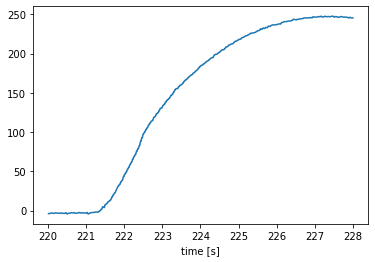

In [5]:
## Cut down to important part:
mask = (df_all['time [s]'] > 220) & (df_all['time [s]'] < 228)
df_asc = df_all.loc[mask] # Cut Data Frame with mask
df_asc.set_index('time [s]', inplace=True) # Set time as the index
df_asc['alt [m]'].plot()

### Barometer Timing

<AxesSubplot:xlabel='time [s]'>

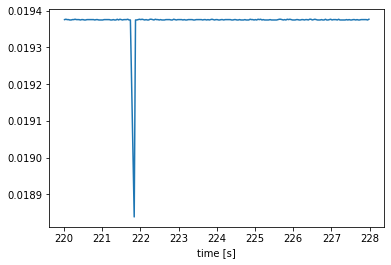

In [6]:
## Get every 10th row -> New reading from Baro every 10th logging cycle
df_baro = df_asc.iloc[::10, :]
df_baro['dt [s]'].plot() # Almost always 0.019376 s (approx. 50 Hz)

### Velocity

<AxesSubplot:xlabel='time [s]'>

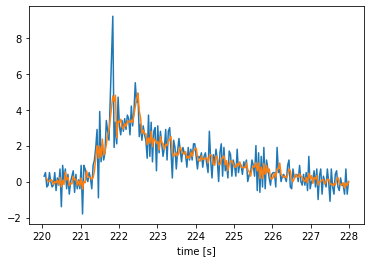

In [7]:
## VELOCITY
dt = 0.019376 + 9* 0.00168; # Update time of barometer (approx)
dh = df_baro['alt [m]'].diff(1)
dh_smooth = df_baro['alt [m]'].rolling(3).mean().diff(1)
dh.plot()
dh_smooth.plot()

<AxesSubplot:xlabel='time [s]'>

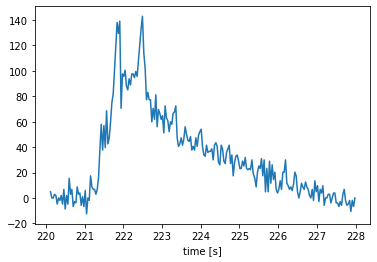

In [8]:
v = dh_smooth/dt
v.plot()

### Acceleration

a_max 910.3840241611908 m/s^2, g_max =  92.8016334517014


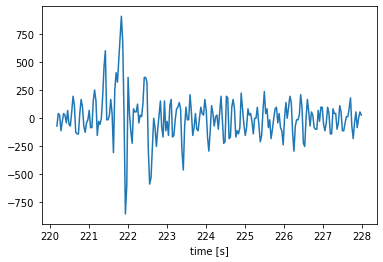

In [9]:
## Acceleration
dv = v.rolling(2).mean().diff(1)
a = dv/dt
a.plot()

print('a_max', a.max(), 'm/s^2, g_max = ', a.max()/9.81)

### Comparison Energy

In [24]:
## Kinetic Energy
print(v.max(), 'm/s')
m = 0.067 # kg
E_kin = 0.5 * m * v.max()**2
print(E_kin, 'J')

# Comparison to a biker
E_kin_biker = 0.5 * 70 * 5**2 # 16 km/h, 70 kg
print(E_kin_biker, 'J')

143.0117501546074 m/s
685.1540828565089 J
875.0 J


## Debug

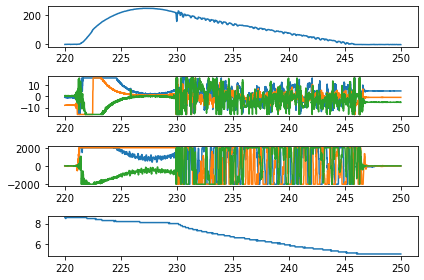

In [11]:
fig, axs = plt.subplots(4)
axs[0].plot(df['alt [m]'])
axs[1].plot(df[['aX [m/s^2]','aY [m/s^2]', 'aZ [m/s^2]']])
axs[2].plot(df[['gX [°/s]','gY [°/s]', 'gZ [°/s]']])
axs[3].plot(df['temp [C]']) # Replace 'another_column' with the actual column name

plt.tight_layout()
plt.show()

In [12]:
# Set the precision to 15 (you can increase this number for even higher precision)
np.set_printoptions(precision=5)
log_floats

array([(  1.272, 0.02776, 5.41, -4.07, -1.33, 161.8, 299.5, -214.1,  0. , 0. , 0.),
       (  1.274, 0.00168, 5.31, -4.12, -1.41, 161.8, 326.4, -208.3,  0. , 0. , 0.),
       (  1.276, 0.00168, 5.23, -4.05, -1.37, 161.9, 349.3, -202. ,  0. , 0. , 0.),
       ...,
       (296.457, 0.01937, 4.58, -1.01, -5.4 ,  13.9,  -6.1,    8.5, -4.8, 5.6, 0.),
       (296.459, 0.00168, 4.55, -1.07, -5.44,  12.7,  -2.5,    7.7, -4.8, 5.6, 0.),
       (296.46 , 0.00168, 4.52, -1.04, -5.41,  13.7,  -3.5,    8.7, -4.8, 5.6, 0.)],
      dtype=[('time [s]', '<f8'), ('dt [s]', '<f8'), ('aX [m/s^2]', '<f8'), ('aY [m/s^2]', '<f8'), ('aZ [m/s^2]', '<f8'), ('gX [°/s]', '<f8'), ('gY [°/s]', '<f8'), ('gZ [°/s]', '<f8'), ('alt [m]', '<f8'), ('temp [C]', '<f8'), ('placeholder', '<f8')])

In [13]:
# log['gY'] = log['gY'].astype(np.float64) # Works